In [10]:
# ===============================================================
# Yield Curve Climate Projection - Economically Constrained NS
# ===============================================================
# Autore: Emanuele Migliaccio (2025)
# Descrizione: Calibrazione del modello Nelson-Siegel
# ===============================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime as dt
from pandas_datareader import data as web
from scipy.interpolate import interp1d
from scipy.optimize import least_squares, minimize
import statsmodels.api as sm

In [3]:
# ---------------------------------------------------------------
# 1. Nelson–Siegel functions
# ---------------------------------------------------------------
def ns_loadings(tau, lamb):
    L2 = (1 - np.exp(-tau / lamb)) / (tau / lamb)
    L3 = L2 - np.exp(-tau / lamb)
    return L2, L3

def nelson_siegel(tau, b0, b1, b2, lamb):
    L2, L3 = ns_loadings(tau, lamb)
    return b0 + b1 * L2 + b2 * L3

In [32]:
#---------------------------------------------------------------
# 2. Historical calibration (US Treasury)
# ---------------------------------------------------------------
start, end = dt(2005, 1, 1), dt.today()
fred_tickers = ["DGS1MO","DGS3MO","DGS6MO","DGS1","DGS2","DGS3","DGS5","DGS7","DGS10","DGS20","DGS30"]
maturities_vec = np.array([1/12,3/12,6/12,1,2,3,5,7,10,20,30], float)

print("Scaricamento dati FRED (può richiedere qualche secondo)...")
yields = pd.concat([web.DataReader(t, "fred", start, end) for t in fred_tickers], axis=1)
yields.columns = fred_tickers
yields = yields.dropna(how="all").ffill() / 100.0
df_yields_annual = yields.resample("A").mean()

interp_curves = {}
for year, row in df_yields_annual.iterrows():
    mask = ~row.isna()
    if mask.sum() < 4:
        continue
    f = interp1d(maturities_vec[mask], row[mask].values, kind="cubic", fill_value="extrapolate")
    interp_curves[year.year] = f(maturities_vec)
df_interp = pd.DataFrame(interp_curves, index=maturities_vec).T

def ns_resid(c, x, y): 
    return y - nelson_siegel(x, *c)

ns_params = []
for year, row in df_interp.iterrows():
    y = row.values.astype(float)
    mask = ~np.isnan(y)
    x, y = maturities_vec[mask], y[mask]
    res = least_squares(ns_resid, [0.03,-0.02,0.02,1.5], args=(x,y), method="lm", max_nfev=10000)
    ns_params.append(dict(year=int(year), beta0=res.x[0], beta1=res.x[1], beta2=res.x[2], lambda_=abs(res.x[3])))
ns_params = pd.DataFrame(ns_params).sort_values("year").reset_index(drop=True)
print("Calibrazione NS completata.")

Scaricamento dati FRED (può richiedere qualche secondo)...
Calibrazione NS completata.


/var/folders/1g/gfp8ygm50gld3c1n79n4s9pc0000gn/T/ipykernel_742/3916846770.py:12: FutureWarning: 'A' is deprecated and will be removed in a future version, please use 'YE' instead.
  df_yields_annual = yields.resample("A").mean()
/var/folders/1g/gfp8ygm50gld3c1n79n4s9pc0000gn/T/ipykernel_742/3220860091.py:5: RuntimeWarning: overflow encountered in exp
  L2 = (1 - np.exp(-tau / lamb)) / (tau / lamb)
/var/folders/1g/gfp8ygm50gld3c1n79n4s9pc0000gn/T/ipykernel_742/3220860091.py:6: RuntimeWarning: overflow encountered in exp
  L3 = L2 - np.exp(-tau / lamb)
/var/folders/1g/gfp8ygm50gld3c1n79n4s9pc0000gn/T/ipykernel_742/3220860091.py:6: RuntimeWarning: invalid value encountered in subtract
  L3 = L2 - np.exp(-tau / lamb)


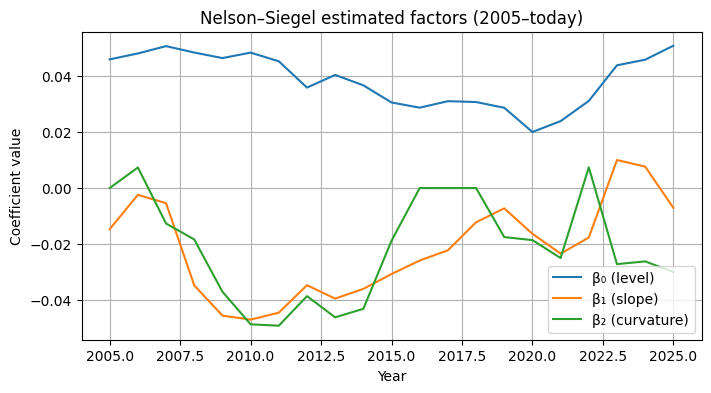

In [34]:
ns_params = pd.DataFrame(ns_params).sort_values("year").reset_index(drop=True)

plt.figure(figsize=(8,4))
plt.plot(ns_params["year"], ns_params["beta0"], label="β₀ (level)")
plt.plot(ns_params["year"], ns_params["beta1"], label="β₁ (slope)")
plt.plot(ns_params["year"], ns_params["beta2"], label="β₂ (curvature)")
plt.title("Nelson–Siegel estimated factors (2005–today)")
plt.xlabel("Year"); plt.ylabel("Coefficient value"); plt.legend(); plt.grid(True); plt.show()

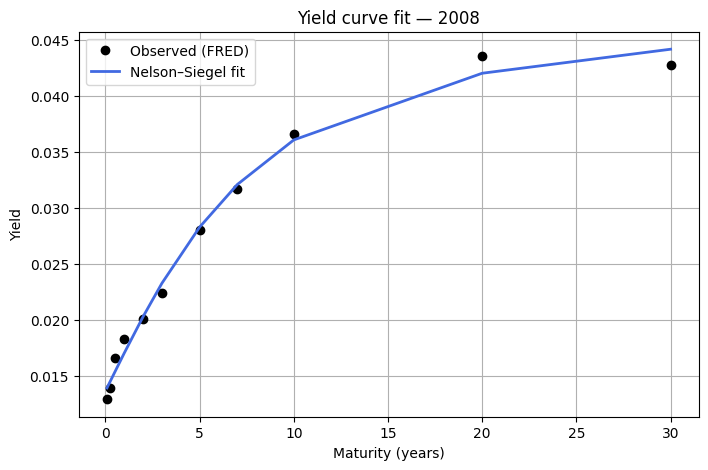

2008: RMSE = 0.000956


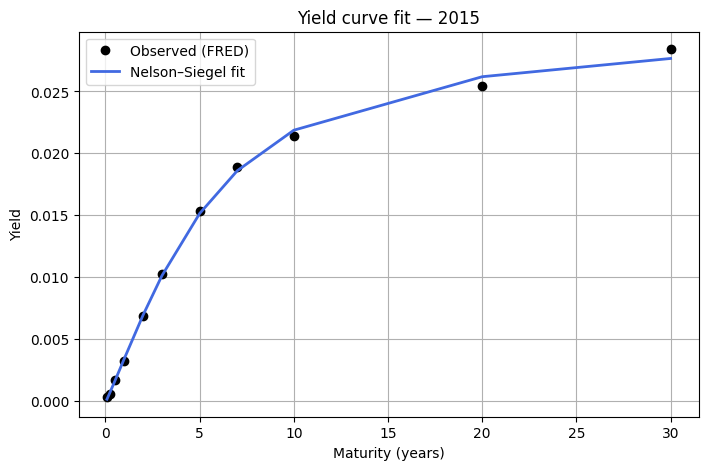

2015: RMSE = 0.000378


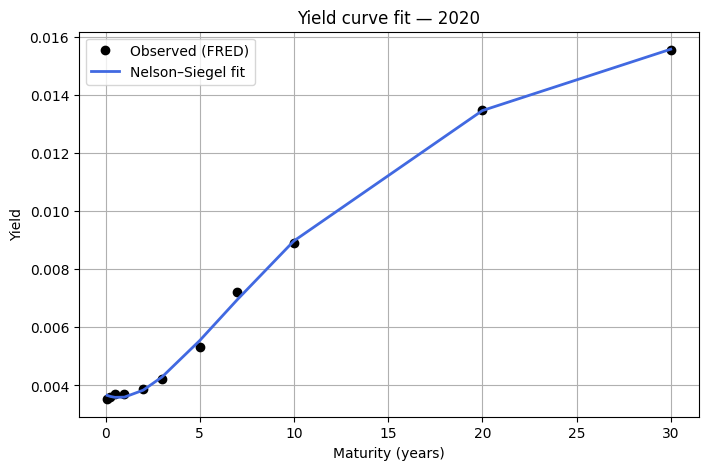

2020: RMSE = 0.000126


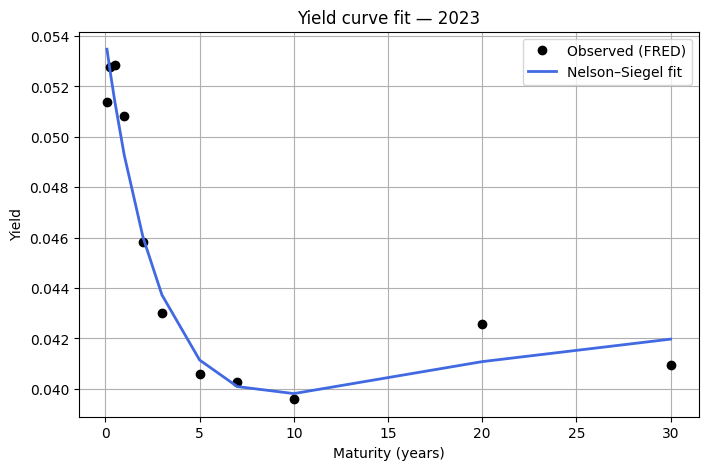

2023: RMSE = 0.001087


In [35]:
# --- 2b. Fit validation: observed vs NS-fitted yields ---
years_to_plot = [2008, 2015, 2020, 2023]
for year in years_to_plot:
    if year not in df_interp.index or year not in ns_params["year"].values:
        continue
    y_obs = df_interp.loc[year].values
    row = ns_params.loc[ns_params["year"] == year].iloc[0]
    y_fit = nelson_siegel(maturities_vec, row["beta0"], row["beta1"], row["beta2"], row["lambda_"])
    plt.figure(figsize=(8,5))
    plt.plot(maturities_vec, y_obs, "o", color="black", label="Observed (FRED)")
    plt.plot(maturities_vec, y_fit, "-", color="royalblue", lw=2, label="Nelson–Siegel fit")
    plt.title(f"Yield curve fit — {year}")
    plt.xlabel("Maturity (years)"); plt.ylabel("Yield"); plt.legend(); plt.grid(True); plt.show()
    rmse = np.sqrt(np.nanmean((y_obs - y_fit)**2))
    print(f"{year}: RMSE = {rmse:.6f}")
